In [3]:
import torch
import torch.nn.functional as F
import cv2
from torchvision import transforms

# --------------------------
# Load pretrained models
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "RIB-RIB.h4"


# Step 2.2: Load the state dictionary (the weights) from the file
state_dict = torch.load(model_path, map_location=device)

/tmp/ipykernel_3157533/165998683.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

# Define the model with Batch Normalization in ResidualInceptionBlock
class RIB(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(RIB, self).__init__()
        self.conv_initial = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=True)
        self.bn_initial = nn.BatchNorm2d(out_channels)
        self.leaky_relu_initial = nn.LeakyReLU(negative_slope=0.01)

        self.conv1x1 = nn.Conv2d(out_channels, out_channels // 2, kernel_size=1, stride=1, padding=0 , bias=True)
        self.leaky_relu1x1 = nn.LeakyReLU(negative_slope=0.01)

        self.conv3x3 = nn.Conv2d(out_channels, out_channels // 2, kernel_size=3, stride=1, padding=1 , bias=True)
        self.leaky_relu3x3 = nn.LeakyReLU(negative_slope=0.01)

        self.conv_final = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0 , bias=True)
        self.bn_final = nn.BatchNorm2d(out_channels)
        self.leaky_relu_final = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x_initial = self.conv_initial(x)
        x_initial = self.bn_initial(x_initial)
        x_initial = self.leaky_relu_initial(x_initial)

        branch1 = self.conv1x1(x_initial)
        branch1 = self.leaky_relu1x1(branch1)

        branch2 = self.conv3x3(x_initial)
        branch2 = self.leaky_relu3x3(branch2)

        out = torch.cat([branch1, branch2], dim=1)
        out = self.conv_final(out)
        out = self.bn_final(out)
        out = self.leaky_relu_final(out)

        out = out + x_initial
        return out



class Classifier(nn.Module):
    def __init__(self, num_classes=9, dropout_prob=0.5):
        super(Classifier, self).__init__()
        self.rib1 = RIB(in_channels=3, out_channels=32)
        self.rib2 = RIB(in_channels=32, out_channels=64)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_prob)

        # Two fully connected layers:
        # fc1: transforms the 64 pooled features to a hidden layer (e.g., 128 units)
        # fc2: transforms the hidden layer to the output classes
        self.fc1 = nn.Linear(64, 128, bias=True)  # Intermediate fully connected layer
        self.fc2 = nn.Linear(128, num_classes, bias=True)  # Output fully connected layer64, 128, bias=False)  # Intermediate fully connected layer


    def forward(self, x):
        x = self.rib1(x)
        x = self.rib2(x)
        x = self.global_pool(x)  # Output shape: [batch_size, 64, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 64]

        # Apply dropout, then the first FC layer with ReLU activation
        # x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)

        # Optional: Apply dropout again before the final layer
        x = self.dropout(x)
        x = self.fc2(x)

        # Softmax over the class dimension
        x = F.softmax(x, dim=1)
        return x

# Instantiate and send model to device (GPU if available)
model = Classifier(num_classes=9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import random_split
from torchvision import transforms
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:


class Blurry(nn.Module):
    def __init__(self):
        super(Blurry, self).__init__()
        # Encoder: Convolutional Layers
        self.encoder = nn.Sequential(
            # --- Block 1 ---
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),   # Input: 3x256x256 -> Output: 32x256x256
            nn.LeakyReLU(negative_slope=0.01),

            # --- Block 2 ---
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Input: 32x256x256 -> Output: 64x256x26
            nn.LeakyReLU(negative_slope=0.01),
        )

        # Decoder: Fully Connected Layers
        self.decoder = nn.Sequential(
            # The input size is now much larger because pooling was removed
            # It must match the encoder's output: 64 channels * 256 height * 256 width
            nn.Linear(64 * 256 * 256, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 256 * 256 * 3),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional Encoder
        x = self.encoder(x)

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)

        # Fully Connected Decoder
        x = self.decoder(x)

        # Reshape to image dimensions
        return x.view(x.size(0), 3, 256, 256)


BLR_model = Blurry().to(device)


In [7]:

class Contrast_Hazy(nn.Module):
    def __init__(self):
        super(Contrast_Hazy, self).__init__()
        # Encoder is fine
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(),
        )

        # ? WARNING: A linear decoder like this is not good for images.
        # The size has been drastically reduced just to make the code runnable.
        self.decoder = nn.Sequential(
            nn.Linear(32 * 32 * 64, 128), # Reduced from billions of parameters
            nn.ReLU(),
            nn.Linear(128, 256 * 256 * 3),
            nn.Sigmoid(), # Outputs pixel values in the [0, 1] range
        )

    def forward(self, x):
        x = self.encoder(x)

        # ? CORRECTED: This is the proper way to flatten the tensor.
        # It reshapes the output of the encoder into a 1D vector for the linear layers.
        x = x.view(x.size(0), -1)

        x = self.decoder(x)

        # Reshape the final vector back into an image
        return x.view(x.size(0), 3, 256, 256)


CH_model = Contrast_Hazy().to(device)

In [8]:
class Illumination(nn.Module):
    def __init__(self):
        super(Illumination, self).__init__()
        # Encoder: Convolutional Layers
        self.encoder = nn.Sequential(
            # --- Block 1 ---
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),   # Input: 3x256x256 -> Output: 32x256x256
            nn.LeakyReLU(negative_slope=0.01),

            # --- Block 2 ---
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Input: 32x256x256 -> Output: 64x256x26
            nn.LeakyReLU(negative_slope=0.01),
        )

        # Decoder: Fully Connected Layers
        self.decoder = nn.Sequential(
            # The input size is now much larger because pooling was removed
            # It must match the encoder's output: 64 channels * 256 height * 256 width
            nn.Linear(64 * 256 * 256, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 256 * 256 * 3),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional Encoder
        x = self.encoder(x)

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)

        # Fully Connected Decoder
        x = self.decoder(x)

        # Reshape to image dimensions
        return x.view(x.size(0), 3, 256, 256)

IRGB_model = Illumination().to(device)

In [9]:
IRGB_model

Illumination(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4194304, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=196608, bias=True)
    (5): Sigmoid()
  )
)

In [10]:
class Noisy(nn.Module):
    def __init__(self):
        super(Noisy, self).__init__()
        input_size= 256 *256*3
        self.input_size = input_size
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(64, 32),
            nn.LeakyReLU(negative_slope=0.01),

        )
        self.decoder = nn.Sequential(

            nn.Linear(32, 64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(64, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, input_size),
            nn.Sigmoid(),  # Sigmoid for pixel values between 0 and 1
        )

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        # Reshape the output tensor to image dimensions
        x = x.view(x.size(0), 3, 256, 256)
        return x

NSY_model = Noisy().to(device)

In [11]:
# --------------------------
# Helper: Select model based on degradation
# --------------------------
def select_model(degradation):
    if degradation in ["LIL", "CBR", "CBG", "CBB"]:
        return IRGB_model
    elif degradation in ["HZY", "LCN"]:
        return CH_model
    elif degradation == "BLR":
        return BLR_model
    elif degradation == "NSY":
        return NSY_model
    else:
        return None  # for clear images

Using device: cuda

Loading all models, please wait...


/tmp/ipykernel_3157533/2645442344.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_paths[name], map_location=device))


All models loaded successfully.
   Enhancement complete.
   Enhancement complete.
   Enhancement complete.

🏁 Reached maximum of 3 iterations.

✅ Pipeline finished. Displaying results...


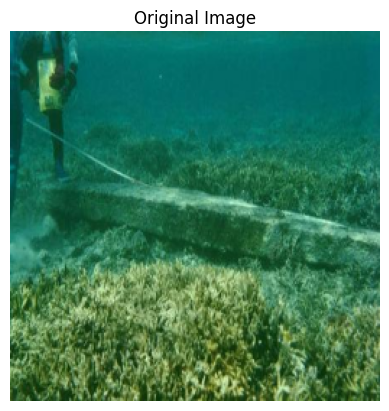

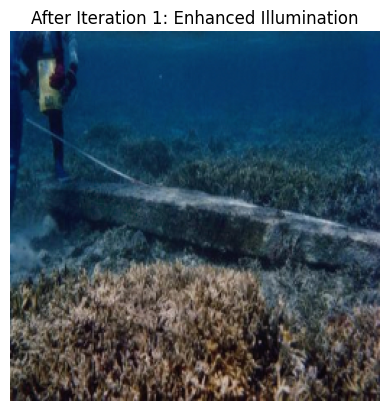

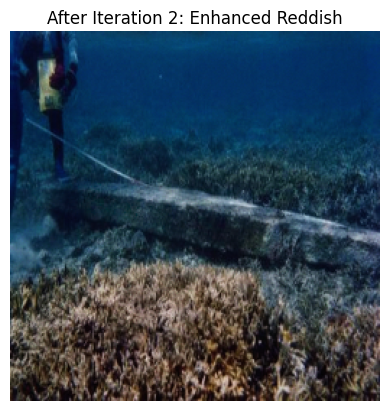

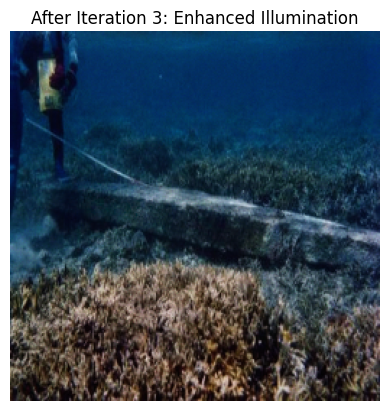

In [33]:
# Maps classifier output names to the name of the model that should handle it.
DEGRADATION_MAP = {
    # This order MUST match the output order of your classifier's final layer.
    "Illumination": "IRGB_Model",
    "Reddish":      "IRGB_Model",
    "Bluish":       "IRGB_Model",
    "Greenish":     "IRGB_Model",
    "Contrast":     "CH_Model",
    "Hazy":         "CH_Model",
    "Blurry":       "BLR_Model",
    "Noisy":        "NSY_Model",
    "Clear":        None  # 'None' signifies that no enhancement is needed.
}

# Define the maximum number of enhancement iterations.
NUM_ITERATIONS = 3

# --- 3. Helper Functions ---

def preprocess_image(image_path, device):
    """Loads and preprocesses an image for model input."""
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor() # Scales image to [0, 1]
    ])
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor.to(device)

def classify_degradation(image_tensor, classifier_model, previous_degradation=None):
    """
    Classifies degradation. If the top prediction is the same as the previous one,
    it returns the second-highest prediction instead.
    """
    # print("-> Classifying degradation...")
    classifier_model.eval()
    with torch.no_grad():
        output = classifier_model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        
        # Get the top 2 probabilities and their indices
        top2_probs, top2_indices = torch.topk(probabilities, 2, dim=1)

    class_names = list(DEGRADATION_MAP.keys())

    # Print all class probabilities for better insight
    # print("   Softmax Probabilities:")
    # for i, class_name in enumerate(class_names):
    #     print(f"     - {class_name:<15}: {probabilities[0, i].item():.4f}")

    # Determine the top prediction
    top1_idx = top2_indices[0, 0].item()
    predicted_class = class_names[top1_idx]
    confidence = top2_probs[0, 0].item()

    # If the top prediction is the same as the last one, take the second-highest
    if previous_degradation is not None and predicted_class == previous_degradation:
        # print(f"\n   '{predicted_class}' was already corrected. Taking 2nd highest probability.")
        top2_idx = top2_indices[0, 1].item()
        predicted_class = class_names[top2_idx]
        confidence = top2_probs[0, 1].item()

    # print(f"\n   Predicted degradation: {predicted_class} (Confidence: {confidence:.2%})")
    return predicted_class

def enhance_image(image_tensor, enhancement_model):
    """Enhances an image using the provided model."""
    model_name = enhancement_model.__class__.__name__
    # print(f"-> Enhancing image with {model_name}...")
    enhancement_model.eval()
    with torch.no_grad():
        enhanced_tensor = enhancement_model(image_tensor)
    
    # Ensure the output is clamped to the valid [0, 1] range for the next iteration
    enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1)
    print("   Enhancement complete.")
    return enhanced_tensor

def visualize_tensor(image_tensor, title=""):
    """Visualizes a PyTorch tensor as an image using matplotlib."""
    # Squeeze the batch dimension, move to CPU, and permute channels for matplotlib
    image = image_tensor.squeeze(0).cpu().permute(1, 2, 0).detach().numpy()
    
    # Clip values to [0, 1] to prevent matplotlib warnings
    image = np.clip(image, 0, 1)
    
    plt.figure()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# --- 4. Main Inference Pipeline ---
def main_pipeline(input_image_path):
    """Runs the full iterative enhancement pipeline and visualizes results."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Load All Models ---
    print("\nLoading all models, please wait...")
    try:
        # Map model names to their class definitions
        model_classes = {
            "Classifier": Classifier(num_classes=len(DEGRADATION_MAP)),
            "IRGB_Model": Illumination(),
            "CH_Model": Contrast_Hazy(),
            "BLR_Model": Blurry(),
            "NSY_Model": Noisy()
        }
        
        # Map model names to their weight file paths
        model_paths = {
            "Classifier": 'RIB-RIB.h4',
            "IRGB_Model": 'IRGB_model.pth',
            "CH_Model": 'hazyContrast_model.pth',
            "BLR_Model": 'blurryt_model.pth',
            "NSY_Model": 'noisy_model.pth'
        }

        # Load all models into a dictionary
        loaded_models = {}
        for name, model in model_classes.items():
            model.load_state_dict(torch.load(model_paths[name], map_location=device))
            model.to(device)
            model.eval()
            loaded_models[name] = model

        classifier_model = loaded_models["Classifier"]
        
    except FileNotFoundError as e:
        print(f"\n--- FATAL ERROR ---")
        print(f"Model file not found: {e.filename}")
        print("Please ensure all model paths are correct and the files exist in the same directory.")
        return
    except Exception as e:
        print(f"\n--- FATAL ERROR ---")
        print(f"An error occurred while loading models: {e}")
        print("Please check your model architectures and weight files.")
        return

    print("All models loaded successfully.")

    # --- Start Processing ---
    current_image_tensor = preprocess_image(input_image_path, device)
    visualize_tensor(current_image_tensor, title="Original Image")
    
    previous_degradation_type = None

    for i in range(NUM_ITERATIONS):
        # print(f"\n================ ITERATION {i + 1}/{NUM_ITERATIONS} ================")
        
        # 1. Classify the degradation, passing the previous type to avoid repeats
        degradation_type = classify_degradation(current_image_tensor, classifier_model, previous_degradation=previous_degradation_type)

        if degradation_type == "Clear":
            print("Image is classified as Clear. Stopping iterations.")
            break

        # 2. Select the appropriate enhancement model
        model_name_to_use = DEGRADATION_MAP.get(degradation_type)
        enhancement_model = loaded_models.get(model_name_to_use)

        if enhancement_model is None:
            print(f"Warning: No model found for degradation '{degradation_type}'. Skipping enhancement.")
            previous_degradation_type = degradation_type # Store it even if skipped
            continue

        # 3. Enhance the image
        current_image_tensor = enhance_image(current_image_tensor, enhancement_model)
        
        # 4. Store the degradation type that was just corrected
        previous_degradation_type = degradation_type
        
        # 5. Visualize the result of this iteration
        visualize_tensor(current_image_tensor, title=f"After Iteration {i+1}: Enhanced {degradation_type}")
    else:
        print(f"\n🏁 Reached maximum of {NUM_ITERATIONS} iterations.")

    print("\n✅ Pipeline finished. Displaying results...")
    plt.show()


# --- 5. Execution ---
if __name__ == "__main__":
    # --- IMPORTANT ---
    # 1. Update your model architectures in Section 1.
    # 2. Ensure your saved model files exist in the same directory as this script.
    # 3. Update the INPUT_IMAGE path to your test image.

    INPUT_IMAGE = "/home/pguha3/Dataset/greenish/106_img_.png"

    # Check if the input image exists before running the pipeline
    if os.path.exists(INPUT_IMAGE):
        main_pipeline(INPUT_IMAGE)
    else:
        print(f"--- FATAL ERROR ---")
        print(f"Input image not found at: '{INPUT_IMAGE}'")
        print("Please ensure the path is correct and the file exists.")